# 라이브러리

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


# Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

sunnysai12345/News_Summary
https://github.com/sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드할 수 있어요.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
91889,Jadavpur University centre of Naxalite ideolog...,Condemning the Naxal attack on CRPF personnel ...
65879,"Military ID scam busted in China, over 270 held",Over 270 people have been arrested in China fo...
41349,Fake Ã¢ÂÂ¹2000 notes smuggled from B'desh for...,India's Directorate of Revenue Intelligence ha...
90587,"MakeMyTrip to raise Ã¢ÂÂ¹2,115 crore via shar...",Online travel firm MakeMyTrip on Wednesday sai...
55284,UN orders N Koreans working abroad to return h...,The United Nations Security Council on Friday ...
91791,I was in a relationship with my rapist: Hollyw...,"Hollywood actress Abigail Breslin, while expla..."
82640,Director accuses Toilet- Ek Prem Katha makers ...,Filmmaker Praveen Vyas has sent a legal notice...
55815,Apple India head Sanjay Kaul quits: Report,Technology giant Apple's head in India Sanjay ...
47641,Thai Prime Minister releases pop song on YouTube,A new pop song written by Thailand's Prime Min...
34868,Supreme Court's website hacked by 'Brazil Hack...,Soon after the Supreme Court dismissed pleas s...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [4]:
data.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

편하게 하기위해 이름을 바꾸었다.

## 중복 샘플과 NULL 값이 존재하는 샘플 제거
우선 데이터의 중복 샘플 유무를 확인해 볼게요.

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
# 결측치를 확인합니다.
print(data.isnull().sum())

Summary    0
Text       0
dtype: int64


In [8]:
# 결측치를 제거합니다.
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 텍스트 정규화와 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# 불용어 사전 - 문맥과 무관하게 자주 나와 context vector에 담겨있는 정보를 희석할 
#               염려가 있는 단어는 사용하지 않도록 합니다.
 
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

불용어 사전에서 의문이 드는 점은, 부정어(no, not, nor, but)등도 포함되어 있다는 점인데, 이들은 사용하도록 하겠습니다. 또한, 뉴스에서 의미를 파악하는데 중요할 것 같은 단어도 사용하도록 하겠습니다

In [12]:
selection = ['but', 'no', 'not', 'nor', 'only', 'while', 'before', 'after', 'under', \
            'again', 'further']

my_stopwords = list(
                    filter(lambda word: word not in selection,
                        stopwords.words('english')
                        )
                    )

In [13]:
print('사용자화 불용어 개수: ', len(my_stopwords))
print(my_stopwords)

사용자화 불용어 개수:  168
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "

정규표현식과 불용어 사전을 이용해 전처리를 진행합니다

In [14]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, ```<br />```과 같은 ```html``` 태그가 제거되었죠. (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 또한 특수문자가 제거되면서 영어만 남았어요.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 

이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.

In [16]:
# data.to_csv('clean_data.csv') #전처리 후 데이터 백업

In [17]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

이제 Summary에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요.

In [18]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [19]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [20]:
data.isnull().sum()

Summary    0
Text       0
dtype: int64

없으므로 넘어간다.

In [21]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


자연어 관련 전처리가 완료되었습니다

# 샘플의 최대 길이 정하기
필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


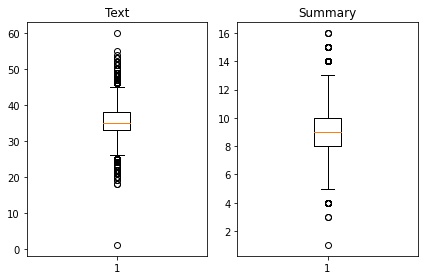

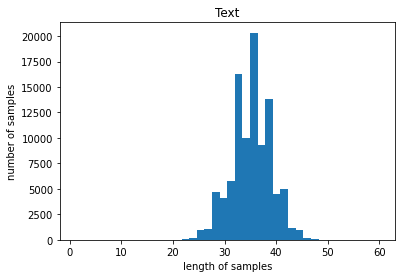

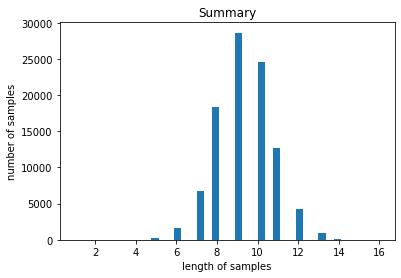

In [22]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 위에서부터 그래프의 의미는 차례대로 아래과 같다.

* Summary 과 실제 Text 의 길이 분포
* 요약본 샘플 길이별 개수
* 실제 텍스트 샘플 길이별 개수
* Text의 경우 최소 길이가 1, 최대 길이가 60으로 그 차이가 굉장히 크다. 하지만 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 50 내외의 길이를 가진다는 것을 확인 할 수 있다.

Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이가 매우 짧다. 그래프로 봤을 때에도 대체적으로 11이하의 길이를 가지고 있다.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정하자.

In [23]:
text_max_len = 50
summary_max_len = 12
print('=3')

=3


In [24]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [25]:
# 최소, 최대 사이에 있는 샘플을 골라 냅니다.
def bandpass_len(min_len, max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len) and (len(s.split()) >= min_len):
            cnt = cnt + 1
    print(f'전체 샘플 중 길이가 {min_len} 이상,{max_len} 이하인 샘플의 비율:{cnt / len(nested_list)}')

In [26]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [27]:
bandpass_len(1,29, data['Text'])
bandpass_len(1,6,data['Summary'])

전체 샘플 중 길이가 1 이상,29 이하인 샘플의 비율:0.06987596583977226
전체 샘플 중 길이가 1 이상,6 이하인 샘플의 비율:0.019662464416429444


In [28]:
bandpass_len(30,50, data['Text'])
bandpass_len(7,12,data['Summary'])

전체 샘플 중 길이가 30 이상,50 이하인 샘플의 비율:0.9299816998779992
전체 샘플 중 길이가 7 이상,12 이하인 샘플의 비율:0.9683712891419276


텍스트 비율은 30이상 50이하 이렇게 쓰기로했다.
요약은 7이상 12이하로 하겠다.

In [29]:
text_max_len = 46; text_min_len = 30

In [30]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len \
            and len(x.split()) >= text_min_len)]

In [31]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 90280


In [32]:
summary_max_len = 13; summary_min_len = 7

In [33]:
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len \
            and len(x.split()) >= summary_min_len)]

In [34]:
data
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88510


In [35]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [36]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장 
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 랜덤 섞기

In [37]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[16288 10392 69445 ... 71375 18913 11991]


In [38]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


## 훈련데이터 테스트 데이터 분리

In [39]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17702


In [40]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 70808
훈련 레이블의 개수 : 70808
테스트 데이터의 개수 : 17702
테스트 레이블의 개수 : 17702


# 데이터 전처리 - 정수 인코딩
## 단어 집합(vocabulary) 만들기 및 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 고유한 정수로 맵핑하는 적업이 필요하다. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현한다.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [41]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

현재 생성된 단어 집합은 ```src_tokenizer.word_index``` 에 저장되어 있다.

만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외한다.

```src_tokenizer.word_counts.items()``` 를 사용하여 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [42]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67099
등장 빈도가 6번 이하인 희귀 단어의 수: 45823
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21276
단어 집합에서 희귀 단어의 비율: 68.29162878731427
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.692618409350681


* 등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 68% 이상을 차지함.
* 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.68%밖에 되지 않음.
* 그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다.

* 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 21,000으로 제한한다.

In [43]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 12,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다.

현재 단어 집합의 크기를 12,000으로 제한했으니까 이제 12,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다

In [44]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[0])

[104, 840, 358, 2199, 801, 609, 8348, 686, 7153, 6317, 1575, 5206, 11, 314, 55, 2199, 801, 277, 16791, 14156, 609, 8348, 370, 1495, 1852]


In [45]:
# 전체 단어 집합과 각 단어에 대한 빈도수를 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [46]:
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29058
등장 빈도가 5번 이하인 희귀 단어의 수: 19175
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9883
단어 집합에서 희귀 단어의 비율: 65.98871223071099
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.011720440118958


In [47]:
# 5,000을 단어 집합의 크기로 제한
tar_vocab = 9400
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 57, 369, 1194, 1497, 3, 75, 652, 5, 731], [1, 145, 1902, 711, 17, 3, 794, 66, 3648, 795], [1, 29, 69, 91, 1044, 145, 93, 123, 7, 1355, 2213], [1, 7237, 186, 12, 50, 3, 2634, 1023, 704, 73], [1, 63, 6466, 213, 22, 5, 1195, 60, 3, 5315]]
target
decoder  [[57, 369, 1194, 1497, 3, 75, 652, 5, 731, 2], [145, 1902, 711, 17, 3, 794, 66, 3648, 795, 2], [29, 69, 91, 1044, 145, 93, 123, 7, 1355, 2213, 2], [7237, 186, 12, 50, 3, 2634, 1023, 704, 73, 2], [63, 6466, 213, 22, 5, 1195, 60, 3, 5315, 2]]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.

```decoder_input```에는 ```sostoken``` 또는 ```decoder_target```에는 ```eostoken```이 추가된 상태이므로 길이가 0이 된 요악문의 실제 길이는 1로 나올 것이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 ```drop_train```과 ```drop_test```에 라는 변수에 저장하고 샘플들은 모두 삭제한다.

In [48]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 70808
훈련 레이블의 개수 : 70808
테스트 데이터의 개수 : 17702
테스트 레이블의 개수 : 17702


겹치는게 없다.

## 패딩하기
최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 아까 정해두었던 최대 길이로 길이를 맞춘다.

In [49]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 모델 설계
함수형 API 를 이용해서 인코더를 설계한다.

In [50]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

#인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4 )
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# # 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# # 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# # 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내야한다.

In [51]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다.

하지만 LSTM의 입력을 정의할 때, ```initial_state```의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야한다.

In [52]:
# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 46, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# 어텐션 메커니즘
지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq 이다.

디코더의 출력층의 설계를 수정해서 성능을 높일 수 있는 방법인 어텐션 메커니즘을 사용해보자.

깃허브에 공개되어있는 어텐션 함수를 다운로드하자.

In [53]:
#urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
# from attention import AttentionLayer

In [54]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 46, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동한다.

In [55]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
277/277 [==============================] - 59s 113ms/step - loss: 5.2386 - val_loss: 4.8120
Epoch 2/50
277/277 [==============================] - 31s 112ms/step - loss: 4.6862 - val_loss: 4.4879
Epoch 3/50
277/277 [==============================] - 31s 111ms/step - loss: 4.3667 - val_loss: 4.2278
Epoch 4/50
277/277 [==============================] - 31s 112ms/step - loss: 4.1289 - val_loss: 4.0681
Epoch 5/50
277/277 [==============================] - 31s 111ms/step - loss: 3.9420 - val_loss: 3.9445
Epoch 6/50
277/277 [==============================] - 31s 112ms/step - loss: 3.7859 - val_loss: 3.8479
Epoch 7/50
277/277 [==============================] - 31s 111ms/step - loss: 3.6501 - val_loss: 3.7693
Epoch 8/50
277/277 [==============================] - 33s 120ms/step - loss: 3.5326 - val_loss: 3.7083
Epoch 9/50
277/277 [==============================] - 59s 212ms/step - loss: 3.4275 - val_loss: 3.6536
Epoch 10/50
277/277 [==============================] - 60s 216ms/step - l

* 조기 종료'를 뜻하는 ```EarlyStopping``` 은 특정 조건이 충족되면 훈련을 멈추는 역할을 한다.

* 위 코드에서는```val_loss```(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정했다.

* 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 하였다.

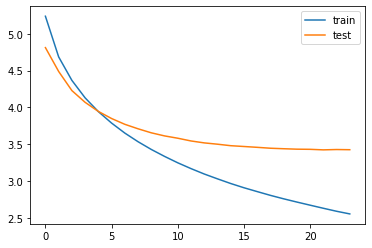

In [56]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 7. 인퍼런스 모델 구현
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해둔다.

In [57]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [58]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [59]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [60]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [61]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [62]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : university chicago led team observed first interactions particles called atom nucleus using world smallest detector measuring inch inch predicted nucleus interactions imagined balls striking bowling ball said physicist study would help look dark matter makes universe mass 
실제 요약 : world smallest detector confirms yr old theory 
예측 요약 :  world cup final was once made


원문 : karnataka government launch poorna scheme october meet needs pregnant women rural areas women provided one full meal including rice dal day apart calcium iron tablets scheme scheme expected benefit nearly lakh women state 
실제 요약 : karnataka to launch scheme for pregnant women 
예측 요약 :  karnataka govt to provide free for women


원문 : following india win australia dharamsala test former australian pacer mitchell johnson said ajinkya rahane continue india captain instead virat kohli rahane stay captain tough series believe stay field players johnson tweeted response article shared cricket australia regarding kohli 

In [63]:
def decode_sequence_penalty(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    #### 이미 나온 단어를 기록하는 set을 만듭니다.
    token_bag = set()
    ####
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #### 만일 예측된 단어가 이미 나온 단어라면, 그 예측치를 15%로 삭감해 다른 토큰이 선택될 수 있도록 합니다
        if sampled_token_index in token_bag:
            output_tokens[0, -1, sampled_token_index] *= 0.15
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
        ####
        
        sampled_token = tar_index_to_word[sampled_token_index]
        
        #### 현재까지 나온 단어를 기록합니다.
        token_bag.add(sampled_token_index)
        ####

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [64]:
for i in range(1680, 1710):
    print('id:', i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence_penalty(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

id: 1680
원문 : former victoria secret model scott knows code slammed trolls post questioning programming abilities come shapes sizes races wrote listing qualifications said think twice doubting women girls encounter tech trying stating facts added 
실제 요약 : victoria secret model who can code shuts down trolls 
예측 요약 :  we are not racist on social media


id: 1681
원문 : chinese scientist jiankui hong kong conference wednesday apologised leak trial results claimed birth world first genetically edited babies clinical trial due current situation added embryos seven couples hiv positive males reportedly altered one resulting birth hiv resistant twins 
실제 요약 : chinese scientist apologises for leak of baby gene editing results 
예측 요약 :  china apologises for cancer sex at world largest site


id: 1682
원문 : metre high replica paris eiffel tower development hangzhou china interestingly community also features square kilometres style architecture although first opened populated often called ghost to

In [65]:
def show_better_expectation(idx):
    print("원문 :", seq2text(encoder_input_test[idx]))
    print("실제 요약 :", seq2summary(decoder_input_test[idx]))
    print("예측 요약(현행) :", decode_sequence(encoder_input_test[idx].reshape(1, text_max_len)))
    print("예측 요약(개선) :", decode_sequence_penalty(encoder_input_test[idx].reshape(1, text_max_len)))
    print("\n")

In [66]:
show_better_expectation(1709)

원문 : wild elephant swept away flood waters saved officials kerala dam shut gates two hours climbed rocky terrain could move water engulfed sides elephant tired water controlled save said forest official nn 
실제 요약 : dam gates closed to rescue elephant in flood hit kerala 
예측 요약(현행) :  kerala floods rescue rescue floods in kerala floods
예측 요약(개선) :  kerala floods rescue floods in flood relief




뭐라는건지 모르겠다. 단어는 맞게나왔다.

# 추출적 요약 해보기

In [67]:
data4 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [68]:
data4 = data4[['text', 'headlines']]
data4.rename(columns = {'text': 'Text', 'headlines': 'Summary'}, inplace = True)

In [69]:
import requests
from summa.summarizer import summarize

In [70]:
print('Summary:')
print(summarize(data4['Text'].apply(str).iloc[1], ratio=0.4))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [71]:
data4['Text'].apply(str).iloc[1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

In [72]:
def summarize_news(idx):
    for i in idx:
        print('원문\n',data4['Text'].apply(str).iloc[i], '\n')
        print('요약\n',summarize(data4['Text'].apply(str).iloc[i], ratio=0.4),'\n\n')
        print('======================================================================================')

In [73]:
summarize_news([30, 400, 5060, 21454, 56645])

원문
 Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday. Mancino was caught off-balance and knocked to the ground after the headbutt. Earlier in the match, Favarin had told his own player to break an opponent's legs. 

요약
 Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday. 


원문
 The death toll from the mine dam collapse in Brazil last week has risen to 58 and more than 300 others are still missing, authorities said. The dam break caused a sea of muddy sludge to bury the cafeteria at the iron-ore mine where workers were eating lunch, before engulfing nearby houses, vehicles and roads. 

요약
  


원문
 Road Transport Minister Nitin Gadkari on Sat

In [74]:
def summarize_news(idx):
    for i in idx:
        print('원문\n',data4['Text'].apply(str).iloc[i], '\n')
        print('요약\n',summarize(data4['Text'].apply(str).iloc[i], ratio=0.05 ),'\n\n')
        print('======================================================================================')

In [75]:
summarize_news([30, 400, 5060, 21454, 56645])

원문
 Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday. Mancino was caught off-balance and knocked to the ground after the headbutt. Earlier in the match, Favarin had told his own player to break an opponent's legs. 

요약
  


원문
 The death toll from the mine dam collapse in Brazil last week has risen to 58 and more than 300 others are still missing, authorities said. The dam break caused a sea of muddy sludge to bury the cafeteria at the iron-ore mine where workers were eating lunch, before engulfing nearby houses, vehicles and roads. 

요약
  


원문
 Road Transport Minister Nitin Gadkari on Saturday said the leadership should have the tendency to own up to defeat and failures, adding that loyalty towards the organisation is not proved until one takes responsibility for defeat. "Success has many fathers but failure i

ratio를 줄이니 원본에 가깝게 나왔다.

In [76]:
def summarize_news(idx):
    for i in idx:
        print('원문\n',data4['Text'].apply(str).iloc[i], '\n')
        print('요약\n',summarize(data4['Text'].apply(str).iloc[i], ratio=0.3, words=10),'\n\n')
        print('======================================================================================')

In [77]:
summarize_news([30, 400, 5060, 21454, 56645])

원문
 Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday. Mancino was caught off-balance and knocked to the ground after the headbutt. Earlier in the match, Favarin had told his own player to break an opponent's legs. 

요약
  


원문
 The death toll from the mine dam collapse in Brazil last week has risen to 58 and more than 300 others are still missing, authorities said. The dam break caused a sea of muddy sludge to bury the cafeteria at the iron-ore mine where workers were eating lunch, before engulfing nearby houses, vehicles and roads. 

요약
  


원문
 Road Transport Minister Nitin Gadkari on Saturday said the leadership should have the tendency to own up to defeat and failures, adding that loyalty towards the organisation is not proved until one takes responsibility for defeat. "Success has many fathers but failure i

In [78]:
def summarize_news(idx):
    for i in idx:
        print('원문\n',data4['Text'].apply(str).iloc[i], '\n')
        print('요약\n',summarize(data4['Text'].apply(str).iloc[i], ratio=0.7),'\n\n')
        print('======================================================================================')

In [79]:
summarize_news([30, 400, 5060, 21454, 56645])

원문
 Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday. Mancino was caught off-balance and knocked to the ground after the headbutt. Earlier in the match, Favarin had told his own player to break an opponent's legs. 

요약
 Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday.
Mancino was caught off-balance and knocked to the ground after the headbutt. 


원문
 The death toll from the mine dam collapse in Brazil last week has risen to 58 and more than 300 others are still missing, authorities said. The dam break caused a sea of muddy sludge to bury the cafeteria at the iron-ore mine where workers were eating lunch, before engulfing nearby houses, v

summarize 함수를 썻을때 첫문장 과 끝문장만 출력되는 느낌을 받았다.

# 회고
불용어에서 의미를 추출해 낼 수 있는 단어는 제외하고, 여러 전처리 방법을 통해 추출적 요약에서 의미있는 결과를 얻었다. inference mode를 수정하여 동어반복을 해결헀다

이 방식으로 제대로 된 요약을 하려면, 임베딩이 잘 되어있는 것이 매우 중요하고, 특히 뉴스의 경우, 빈도수가 작은 단어도 포함시켜야 할 것 같다.


요약을 하는방법은 신기했고, 그중 흥미로운것을 뽑자면

원문 : english premier league side chelsea want send racist supporters trips attend educational courses nazi concentration camp poland instead imposing bans club owner roman jewish reportedly behind new initiative new initiative designed tackle among fans 
실제 요약 : chelsea to send racist fans on nazi camp trips instead of ban 
예측 요약 :  pl pl chelsea footballer to give nazi

이었다.

요약을 이상하게 했었는데, 첼시 팬은 없고, 첼시 선수가 간걸로 요약이됬다. 흔한 가짜뉴스가 만들어졌다. 이런걸로 코드를 짜서, 가짜뉴스를 만들면 세상이 혼란할수도 있겠다는 생각이 들었다.

요약을 정말 잘하고싶었지만, 역시 힘들었고, 모델의 설계또한 학습이 오래걸려서 섣불리 건들기 어려웠다. 

아직은 요약봇이 유의미한 상승세가 없다는 걸 깨달았다.

좀더 공부하도록하자.